**Questions to be Answered**

1. Familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.

2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.

3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.

4. Consider issues such as legends, labels, and chart junk.

5. The data you have been given is near **Ann Arbor, Michigan, United States**, and visualize on map the stations the data.

6. Plot Temperature Summary near Ann Arbor, Michigan, United States (Year 2015).

### Importing essential Libraries for the assignment

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium

### Loading Dataset

In [3]:
df_temperature = pd.read_csv("/content/temperature.csv")
df_bin = pd.read_csv("/content/BinSize.csv")

In [29]:
df_temperature.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,2.2
1,USC00208972,2009-04-29,TMIN,5.6
2,USC00200032,2008-05-26,TMAX,27.8
3,USC00205563,2005-11-11,TMAX,13.9
4,USC00200230,2014-02-27,TMAX,-10.6


In [4]:
df_temperature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165085 entries, 0 to 165084
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   ID          165085 non-null  object
 1   Date        165085 non-null  object
 2   Element     165085 non-null  object
 3   Data_Value  165085 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.0+ MB


### Convert Date column to datetime

In [5]:
df_temperature['Date'] = pd.to_datetime(df_temperature['Date'])

### Remove leap day (Feb 29)

As suggested in question 3,

(Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.)

This will remove Feb 29

In [6]:
df_temperature = df_temperature[~((df_temperature["Date"].dt.month == 2) & (df_temperature["Date"].dt.day == 29))]

### Convert Data_Value to Celsius

* In the dataset, temperature values are stored as tenths of degrees Celsius (e.g., 305 means 30.5°C).
*To convert them to standard degrees Celsius, divide them by 10.

In [7]:
df_temperature["Data_Value"] = df_temperature["Data_Value"] / 10

<ipython-input-7-01af251ed174>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temperature["Data_Value"] = df_temperature["Data_Value"] / 10


### Split dataset into 2005-2014 and 2015 data

For fulfilling questions 1, 2 dataset is split

This step splits the dataset into two DataFrames:
* df_2005_2014 → Contains temperature data from 2005 to 2014.
* df_2015 → Contains temperature data from 2015 only.

**.copy() is used**

* df_temp[df_temp["Date"].dt.year < 2015] creates a view of the original DataFrame.
* Modifying a view can cause unexpected behavior (SettingWithCopyWarning).
* .copy() ensures that we are working with a new, independent DataFrame.

In [8]:
df_2005_2014 = df_temperature[df_temperature['Date'].dt.year < 2015].copy()

In [9]:
df_2015 = df_temperature[df_temperature['Date'].dt.year == 2015].copy()

### Extract day and month (ignoring year) for grouping

* Extracts the month and day from the Date column while ignoring the year.
* It is used to group temperature data by day-of-year (e.g., "01-01" for January 1st, "12-31" for December 31st).
* This allows for comparing daily temperature records across multiple years.

In [10]:
df_2005_2014['DayOfYear'] = df_2005_2014['Date'].dt.strftime('%m-%d')
df_2015['DayOfYear'] = df_2015['Date'].dt.strftime('%m-%d')

### Find record high and low temperatures for each day (2005-2014)

* This code identifies the record high and record low temperatures for each day of the year from 2005 to 2014.
* These records help visualize historical temperature trends.
* They allow for comparison with 2015 to check for record-breaking temperatures

In [11]:
record_high = df_2005_2014[df_2005_2014['Element'] == 'TMAX'].groupby('DayOfYear')['Data_Value'].max()
record_low = df_2005_2014[df_2005_2014['Element'] == 'TMIN'].groupby('DayOfYear')['Data_Value'].min()

### Merge 2015 data with record high/low



In [12]:
df_2015_merged = df_2015.merge(record_high.rename('Record_high'), on='DayOfYear', how ='left')
df_2015_merged = df_2015_merged.merge(record_low.rename('Record_low'), on='DayOfYear', how='left')

In [13]:
df_2015_merged.head()

,ID,Date,Element,Data_Value,DayOfYear,Record_high,Record_low
0,USC00205563,2015-01-03,TMIN,-3.9,01-03,13.3,-26.7
1,USC00203712,2015-03-17,TMAX,18.9,03-17,26.1,-17.8
2,USC00200032,2015-06-06,TMIN,12.8,06-06,34.4,2.8
3,USW00014833,2015-08-30,TMIN,17.8,08-30,34.4,6.7
4,USC00202308,2015-08-30,TMIN,15.6,08-30,34.4,6.7


### Identify record-breaking highs and lows in 2015



In [15]:
high_breakers = df_2015_merged[(df_2015_merged['Element'] == 'TMAX') & (df_2015_merged['Data_Value'] > df_2015_merged['Record_high'])]
low_breakers = df_2015_merged[(df_2015_merged['Element'] == 'TMIN') & (df_2015_merged['Data_Value'] < df_2015_merged['Record_low'])]

### Plot Temperature Records

**This will answer questions 1 and 2.**

* Shows historical temperature patterns from 2005-2014.
* Identifies 2015 as an exceptional year if new records were set.
* The area between the record high and record low temperatures for each day is shaded

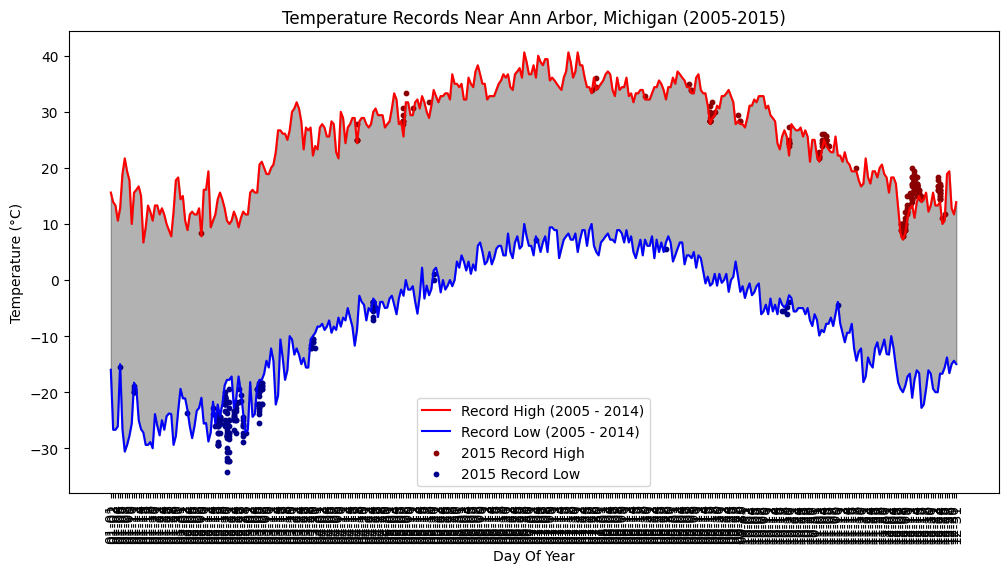

In [22]:

plt.figure(figsize=(12, 6))
plt.plot(record_high.index, record_high.values, label='Record High (2005 - 2014)', color='red')
plt.plot(record_low.index, record_low.values, label='Record Low (2005 - 2014)', color='blue')
plt.fill_between(record_high.index, record_high.values, record_low.values, color='black', alpha=0.3)
plt.scatter(high_breakers['DayOfYear'], high_breakers['Data_Value'], color = 'darkred', label = '2015 Record High', s=10)
plt.scatter(low_breakers['DayOfYear'], low_breakers['Data_Value'], color = 'darkblue', label = '2015 Record Low', s=10)
plt.xticks(rotation = 90)
plt.xlabel('Day Of Year')
plt.ylabel('Temperature (°C)')
plt.title("Temperature Records Near Ann Arbor, Michigan (2005-2015)")
plt.legend()
plt.show()

### Filter stations near Ann Arbor

* Ann Arbor, Michigan, is approximately at 42.28°N, -83.73°W.
* This ensures only stations close to Ann Arbor are included in the analysis.

In [24]:
df_stations_nearby = df_bin[(df_bin['LATITUDE'].between(42.2, 42.5)) & (df_bin['LONGITUDE'].between(-84, -83.5))]


### Create interactive map

As asked in question 4, Visualization on map is done in this

**Why Use folium?**
* Interactive visualization: Users can zoom and pan across the map.
* Easy integration: Works well with Pandas DataFrames.
* Customizable markers: Different colors, icons, and popups make it informative.

In [25]:
# Create interactive map
map_ann_arbor = folium.Map(location=[42.28, -83.73], zoom_start=10)
for _, row in df_stations_nearby.iterrows():
    folium.Marker(
        location=[row["LATITUDE"], row["LONGITUDE"]],
        popup=row["NAME"],
        icon=folium.Icon(color="red", icon="cloud"),
    ).add_to(map_ann_arbor)
map_ann_arbor

### Monthly temperature summary for 2015

Helps to visualize temperature trends over the months of 2015, allowing for an analysis of seasonal changes in Ann Arbor, Michigan.

In [27]:
df_2015['Month'] = df_2015['Date'].dt.month
monthly_high = df_2015[df_2015['Element'] == 'TMAX'].groupby('Month')['Data_Value'].mean()
monthly_low  = df_2015[df_2015['Element'] == 'TMIN'].groupby('Month')['Data_Value'].mean()

### 6. Plot Temperature Summary near Ann Arbor, Michigan, United States (Year 2015).

* Red line: Monthly average high temperatures.
* Blue line: Monthly average low temperatures.
* The trend provides insights into seasonal variations in Ann Arbor, Michigan.

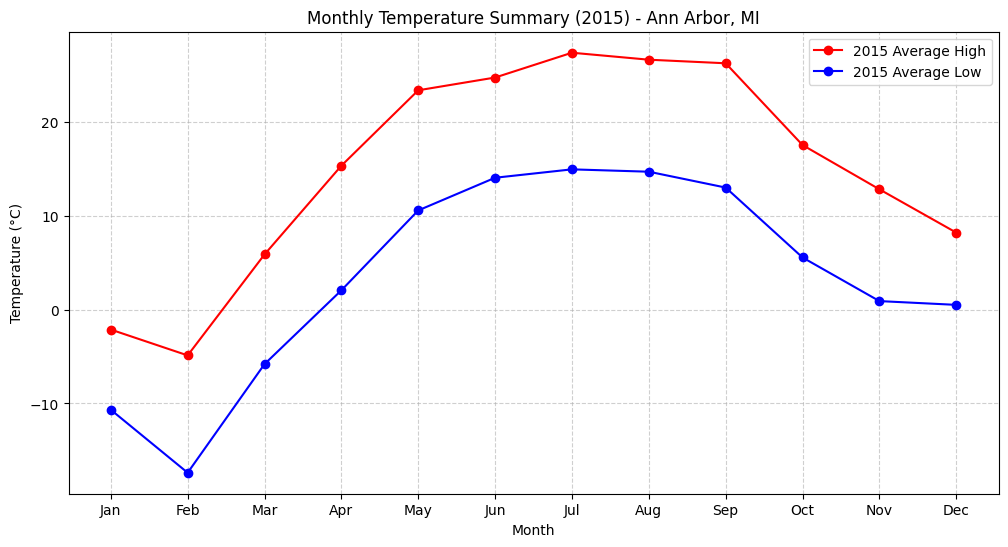

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_high.index, monthly_high.values, marker = 'o', color = 'red', label = '2015 Average High')
plt.plot(monthly_low.index, monthly_low.values, marker = 'o', color = 'blue', label = '2015 Average Low')
plt.xticks(ticks=range(1,13), labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Monthly Temperature Summary (2015) - Ann Arbor, MI')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

**Conclusion**

**Temperature Trends (2005-2015):**

The record high and low temperatures from 2005 to 2014 show clear seasonal variations, with peaks in summer (June–August) and troughs in winter (December–February).
The shaded region between the record highs and lows indicates the historical temperature range for each day of the year.

**Record-Breaking Temperatures in 2015:**

Several record high and low temperatures were broken in 2015, highlighted as scatter points.
These anomalies suggest potential climate variations, extreme weather events, or changes in local environmental conditions.


**Station Locations in Ann Arbor, MI:**

The map visualization shows weather stations around Ann Arbor, Michigan, that contributed to the dataset.
This helps understand the geographical coverage of the data.


**Monthly Temperature Summary (2015):**

Average high temperatures peaked in July and August, aligning with summer.
Average low temperatures were lowest in January and February, reflecting typical winter conditions.


Key Takeaways:

* The dataset provides valuable insights into temperature variations over a decade, useful for climate monitoring.
* 2015 witnessed temperature extremes, indicating possible climate shifts or local anomalies.
* The study highlights the importance of long-term weather data for identifying trends and making climate-related decisions.